<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deeptrack
!pip install --pre deeplay

### **Getting data from Deeptrack**

In [4]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [5]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[6.32037942e-04 6.36917801e-04 6.42338817e-04 ... 9.73989249e+00
 9.74398151e+00 9.74785568e+00]
40960
9.747855680304536
The pixel values are not binary.


### **Plotting the images**

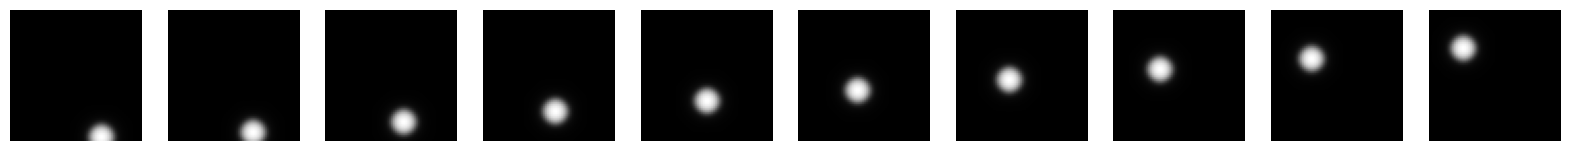

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [7]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        self.std = np.std(all_data)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


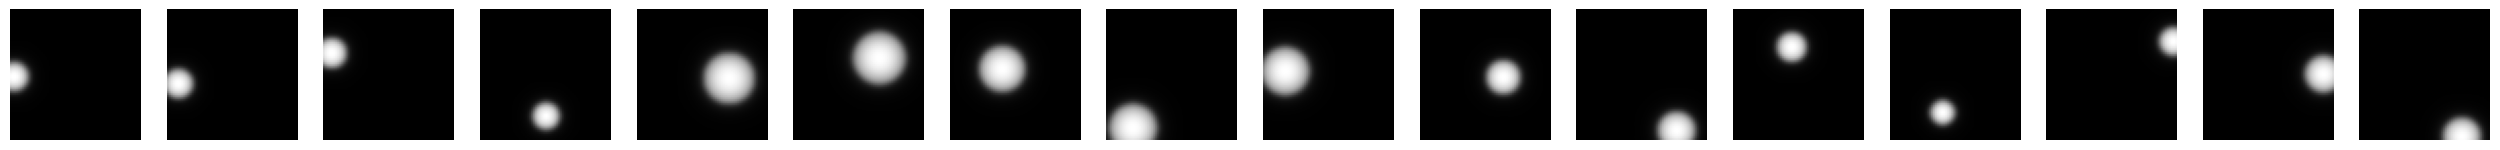

In [8]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            nn.Sigmoid()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [11]:
# Create the model
model = ConvAutoencoder()

In [12]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 25

# Train the network
train_losses, val_losses = train_nn(model, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/25 - Train Loss: 1.1790, Val Loss: 1.0476
Epoch 2/25 - Train Loss: 0.8238, Val Loss: 0.6447
Epoch 3/25 - Train Loss: 0.6149, Val Loss: 0.6119
Epoch 4/25 - Train Loss: 0.6226, Val Loss: 0.6065
Epoch 5/25 - Train Loss: 0.6107, Val Loss: 0.6022
Epoch 6/25 - Train Loss: 0.6107, Val Loss: 0.6006
Epoch 7/25 - Train Loss: 0.5977, Val Loss: 0.6000
Epoch 8/25 - Train Loss: 0.5902, Val Loss: 0.5997
Epoch 9/25 - Train Loss: 0.6140, Val Loss: 0.5995
Epoch 10/25 - Train Loss: 0.6066, Val Loss: 0.5992
Epoch 11/25 - Train Loss: 0.6014, Val Loss: 0.5991
Epoch 12/25 - Train Loss: 0.5877, Val Loss: 0.5991
Epoch 13/25 - Train Loss: 0.5969, Val Loss: 0.5989
Epoch 14/25 - Train Loss: 0.5888, Val Loss: 0.5989
Epoch 15/25 - Train Loss: 0.5861, Val Loss: 0.5990
Epoch 16/25 - Train Loss: 0.5834, Val Loss: 0.5986
Epoch 17/25 - Train Loss: 0.6024, Val Loss: 0.5986
Epoch 18/25 - Train Loss: 0.6106, Val Loss: 0.5985
Epoch 19/25 - Train Loss: 0.5946, Val Loss: 0.5984
Epoch 20/25 - Train Loss: 0.6183, Val Lo

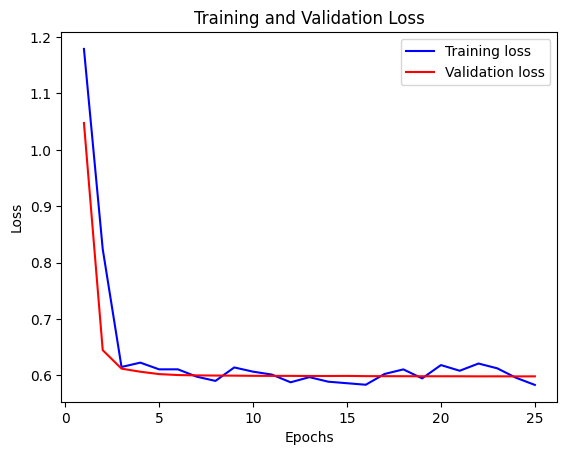

In [13]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot losses
plot_losses(train_losses, val_losses)


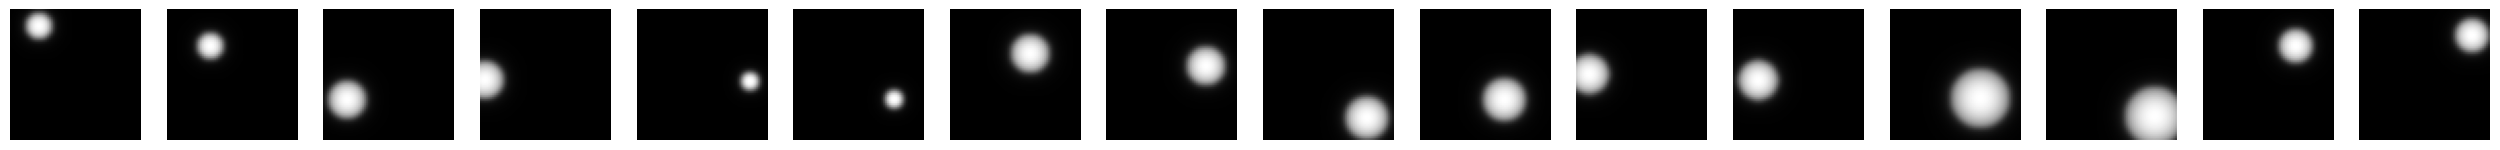

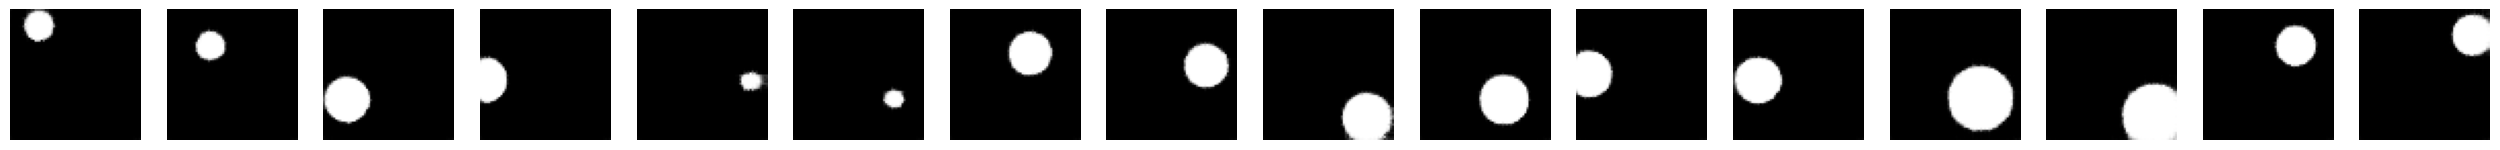

In [14]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:

        outputs = model(images)
        plot_images(images)
        plot_images(outputs)

        break  # Remove break to process more batches